# **Import Libraries**

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [12]:
df = pd.read_csv("nifty50.csv")
df

,Date,Open,High,Low,Close,Shares Traded,Turnover(in cr)
0,01-Jan-18,10531.70,10537.85,10423.10,10435.55,134532090.0,7546.56
1,02-Jan-18,10477.55,10495.20,10404.65,10442.20,158092430.0,8665.47
2,03-Jan-18,10482.65,10503.60,10429.55,10443.20,172516859.0,9541.60
3,04-Jan-18,10469.40,10513.00,10441.45,10504.80,180257392.0,9561.95
4,05-Jan-18,10534.25,10566.10,10520.10,10558.85,186469717.0,10306.22
...,...,...,...,...,...,...,...
1575,14-May-24,22112.90,22270.05,22081.25,22217.85,230238941.0,23741.66
1576,15-May-24,22255.60,22297.55,22151.75,22200.55,231935478.0,23815.79
1577,16-May-24,22319.20,22432.25,22054.55,22403.85,368945092.0,38836.11
1578,17-May-24,22415.25,22502.15,22345.65,22466.10,242654570.0,27388.67


In [13]:
# Parse the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Selecting the feature and target columns
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [14]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# **Model Definition**

In [15]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the last output of the sequence
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Training**

In [17]:
num_epochs = 100
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.08428936451673508
Epoch 2/100, Loss: 0.03413272276520729
Epoch 3/100, Loss: 0.02932879514992237
Epoch 4/100, Loss: 0.015269814990460873
Epoch 5/100, Loss: 0.0016873115673661232
Epoch 6/100, Loss: 0.0016204915009438992
Epoch 7/100, Loss: 0.001348688267171383
Epoch 8/100, Loss: 0.0010311421938240528
Epoch 9/100, Loss: 0.0008721271879039705
Epoch 10/100, Loss: 0.0009025650797411799
Epoch 11/100, Loss: 0.000702537305187434
Epoch 12/100, Loss: 0.000715673144441098
Epoch 13/100, Loss: 0.0009288599831052125
Epoch 14/100, Loss: 0.0014719670871272683
Epoch 15/100, Loss: 0.0008617372368462384
Epoch 16/100, Loss: 0.0005242800689302385
Epoch 17/100, Loss: 0.000660122197587043
Epoch 18/100, Loss: 0.001113884267397225
Epoch 19/100, Loss: 0.0008067919407039881
Epoch 20/100, Loss: 0.0005054828361608088
Epoch 21/100, Loss: 0.0004502783704083413
Epoch 22/100, Loss: 0.0006717979558743536
Epoch 23/100, Loss: 0.0005356194451451302
Epoch 24/100, Loss: 0.0006040361477062106
Epoch 25/100,

# **Prediction and Evaluation**

In [18]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.numpy())

mse = np.mean((predictions - y_test_scaled) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 336484.40625


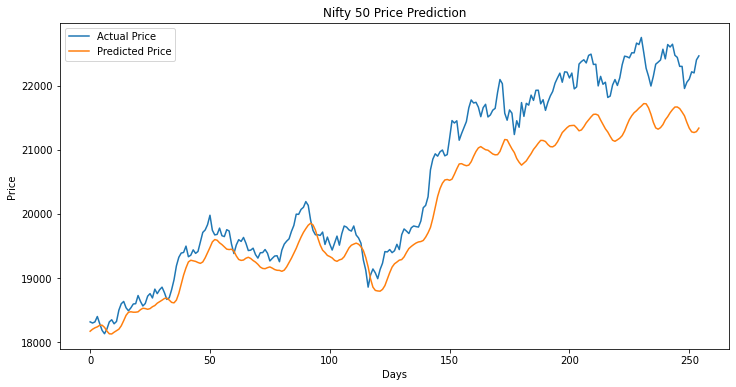

In [19]:
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Nifty 50 Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
next_5_days_predictions = []
last_sequence = X_test[-1:, :, :]

for _ in range(5):
    with torch.no_grad():
        prediction = model(last_sequence)
        next_5_days_predictions.append(scaler.inverse_transform(prediction.numpy()))
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.unsqueeze(2)], dim=1)

print(next_5_days_predictions)

[array([[21339.305]], dtype=float32), array([[21237.836]], dtype=float32), array([[21056.322]], dtype=float32), array([[20840.838]], dtype=float32), array([[20618.885]], dtype=float32)]


In [23]:
# Plotting actual and predicted prices
colors = ['red', 'green', 'blue', 'orange', 'purple']

actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test_scaled.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

# Calculate the next 5 dates after the last date in the dataset
last_date = df.index[-1]
next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plotting prices for the next 5 days
next_5_days_trace = []
predict_price = predictions[-1][0]
for i, price in enumerate(next_5_days_predictions, start=1):
    next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color=colors[i-1]))
    next_5_days_trace.append(next_day_trace)
    last_date = next_5_days_index[i-1]
    predict_price = price[0][0]

# Combine all traces
traces = [actual_trace, predicted_trace] + next_5_days_trace

# Define layout
layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   legend=dict(orientation='h'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


# **Save Model**

In [22]:
# Save the model
torch.save(model.state_dict(), "model.pth")